# Photometric tests of AIS

Created by: Denis

04 March 2024

In [2]:
# Useful functions for the calculation of the photons/s of an astronomical object using AIS

import numpy as np
import pandas as pd
from scipy.constants import c, h

_TELESCOPE_EFFECTIVE_AREA = 0.804  # m2


def read_spectrum_returns_photons_per_sec(file):
    ss = pd.read_csv(file, dtype=np.float64)
    source_wavelength, source_sed = (
        np.asarray(ss["Wavelength (ang)"]) / 10,
        np.asarray(ss["flux (ergs/cm/cm/s/A*10**16)"]) * 1e-7 * 1e4 * 1e10 / 1e16,
    )
    for idx, _ in enumerate(source_sed):
        source_sed[idx] *= (
            _TELESCOPE_EFFECTIVE_AREA * source_wavelength[idx] * 1e-9 / (h * c)
        )
    return source_wavelength, source_sed


# (hss, preamp)
ccd_op_mode = {
    "2023 Mai 05": (1, 2),
    "2023 Mai 06": (1, 1),
    "2023 Jun 06": (1, 1),
    "2022 Nov 12": (1, 1),
    "2022 Nov 10": (1, 1),
    "2023 Abr 06": (1, 1),
    "2023 Abr 09": (1, 1),
    "2024 Jun 27": (1, 2),
}

In [4]:
# CALCULATE AIS E-/S

import os

import pandas as pd

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

base_path = os.path.join("..", "..", "AIS-tests", "photometric tests", "data")
file_path = os.path.join(base_path, "standard stars 2024" + ".csv")
df = pd.read_csv(file_path)

for idx, row in df.iterrows():
    inst_mode = "photometry"
    waveplate = ""
    if row["inst_mode"] != "phot":
        inst_mode = "polarimetry"
        waveplate = "ideal-" + row["inst_mode"]

    date = row["Date"]
    tel_curve = "20230329"
    if "2022" in date:
        tel_curve = "20230328"
    readout, preamp = ccd_op_mode[date]
    ccd_operation_mode = {
        "em_mode": "Conv",
        "em_gain": 1,
        "preamp": preamp,
        "readout": readout,
        "binn": 1,
        "t_exp": 1,  # * e-/s
        "image_size": 100,
    }

    spectrum_file = os.path.join(base_path, "..", "spectrums", row["star"] + ".csv")
    wavelength, sed = read_spectrum_returns_photons_per_sec(spectrum_file)
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, row["Channel"], ccd_temperature=-70
    )
    ais.write_source_sed(wavelength, sed)
    ais.create_sky_sed(moon_phase=row["moon_phase"])
    ais.apply_atmosphere_spectral_response(row["Airmass"], row["sky_condition"])
    ais.apply_telescope_spectral_response(tel_curve)
    ais.apply_sparc4_spectral_response(
        acquisition_mode=inst_mode, retarder_waveplate=waveplate
    )
    ais._integrate_sed()
    star_photons = np.sum(ais.star_photons_per_second)
    df.loc[idx, "AIS flux"] = star_photons
    df.loc[idx, "AIS/observed"] = star_photons / row["flux"]


df.to_csv(file_path, index=False)

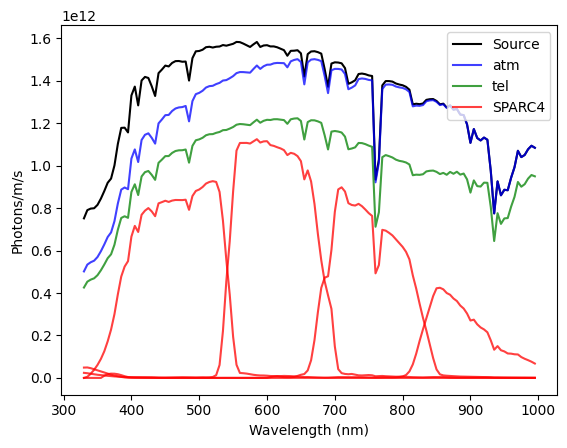

In [2]:
# PLOT SPECTRUMS

import os

import matplotlib.pyplot as plt

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

file = "LTT6248"
base_path = os.path.join("..", "..", "AIS-tests", "photometric tests", "spectrums")
csv_file = os.path.join(base_path, file + ".csv")
source_wavelength, source_sed = read_spectrum_returns_photons_per_sec(csv_file)
ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

ais = Artificial_Image_Simulator(ccd_operation_mode, channel_id=1, ccd_temperature=-70)
ais.write_source_sed(source_wavelength, source_sed)
ais.create_sky_sed(moon_phase="first quarter")
plt.plot(source_wavelength, source_sed, "k", label="Source")
ais.apply_atmosphere_spectral_response(air_mass=1.019)
plt.plot(ais.wavelength, ais.source_sed[0], "b", label="atm", alpha=0.75)
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], "g", label="tel", alpha=0.75)

for channel in [1, 2, 3, 4]:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=channel, ccd_temperature=-70
    )
    ais.write_source_sed(source_wavelength, source_sed)
    ais.create_sky_sed(moon_phase="first quarter")
    ais.apply_atmosphere_spectral_response(air_mass=1.019)
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    lab = ""
    if channel == 1:
        lab = "SPARC4"
    plt.plot(ais.wavelength, ais.source_sed, "r", label=lab, alpha=0.75)

plt.ylabel("Photons/m/s")
plt.xlabel("Wavelength (nm)")
plt.legend(loc="upper right")
fig_file = os.path.join(base_path, "..", "figures", file + ".png")
plt.savefig(fig_file, dpi=300)